In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install patchify
import os
import cv2
import numpy as np
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Dropout
from keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define Jaccard coefficient metric
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    jac = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return jac

# Define Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)
    return 1.0 - dice

# Define Focal Loss
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    ce_loss = -y_true * K.log(y_pred)
    weight = alpha * y_true * K.pow((1 - y_pred), gamma)
    fl_loss = ce_loss * weight
    return K.mean(K.sum(fl_loss, axis=-1))

# Define Total Loss
def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + (1 * focal_loss(y_true, y_pred))

# Load dataset and preprocess as per your previous code
dataset_root_folder = '/kaggle/input/semantic-segmentation-of-aerial-imagery'
dataset_name = 'Semantic segmentation dataset'

image_patch_size = 256
total_classes = 6  # Update this with your total number of classes

# Load images and masks
image_dataset = []
mask_dataset = []
minmaxscaler = MinMaxScaler()

for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Define colors for classes
class_building = np.array([60, 16, 152])
class_land = np.array([132, 41, 246])
class_road = np.array([110, 193, 228])
class_vegetation = np.array([254, 221, 58])
class_water = np.array([226, 169, 41])
class_unlabeled = np.array([155, 155, 155])

# Convert RGB masks to label masks
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:, :, 0]
    return label_segment
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
labels_categorical = to_categorical(labels, num_classes=total_classes)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_categorical, test_size=0.15, random_state=100)

# Define model architecture
def multi_unet_model(n_classes=total_classes, image_height=256, image_width=256, image_channels=3):
    inputs = Input((image_height, image_width, image_channels))

    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1,1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# # Compile the model with total loss
# model = multi_unet_model()
# model.compile(optimizer='adam', loss=total_loss, metrics=['accuracy',jaccard_coef])

# # Print model summary
# model.summary()

# # Train the model
# history = model.fit(X_train, y_train, batch_size=16, epochs=1, verbose=1,validation_data=(X_test, y_test),shuffle=False)

# # Evaluate the model
# scores = model.evaluate(X_test, y_test, verbose=1)
# print("Test Accuracy: %.2f%%" % (scores[1]*100))
# print("Test Jaccard Coefficient: %.2f" % scores[2])

# # Plot training history
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.plot(history.history['jaccard_coef'], label='Training Jaccard Coefficient')
# plt.plot(history.history['val_jaccard_coef'], label='Validation Jaccard Coefficient')
# plt.title('Model Accuracy and Jaccard Coefficient')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy / Jaccard Coefficient')
# plt.legend()
# plt.show()


[ WARN:0@2619.228] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images/image_part_0010.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2619.228] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images/image_part_0011.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2619.228] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images/image_part_0012.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2619.228] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 1/images/image_part_0013.jpg'): can't open/read file: check file path/integrity
[ WARN:0@2619.228] global loadsave.cpp:241 findDecoder imread_('/kag

KeyboardInterrupt: 

In [2]:
model.save('satmodel2.h5')

In [12]:
from keras.models import load_model
import numpy as np
import cv2
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/kaggle/input/satteliteprocessingmodel/other/satmod/1/satmodel.h5', custom_objects={'total_loss': total_loss, 'dice_loss': dice_loss, 'focal_loss': focal_loss, 'jaccard_coef': jaccard_coef})

# Predict on test data
predictions = model.predict(X_test, batch_size=1, verbose=1)

# Assuming predictions are probabilities, convert to categorical labels
predictions_categorical = np.argmax(predictions, axis=-1)

# Define colors for visualization (assuming RGB)
class_colors = {
    0: [0, 0, 255],    # Water (Blue)
    1: [0, 255, 0],    # Land (Green)
    2: [255, 0, 0],    # Road (Red)
    3: [255, 255, 0],  # Building (Yellow)
    4: [0, 255, 255],  # Vegetation (Cyan)
    5: [128, 128, 128] # Unlabeled (Gray)
}

# Convert categorical masks to RGB images
def categorical_to_rgb(mask):
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in class_colors.items():
        mask_rgb[mask == label] = color
    return mask_rgb

# Visualize and compare results
for i in range(len(predictions_categorical)):
    # Original image
    original_image = X_test[i]
    
    # Predicted mask
    predicted_mask = predictions_categorical[i]
    predicted_mask_rgb = categorical_to_rgb(predicted_mask)
    
    # Ground truth mask
    true_mask = np.argmax(y_test[i], axis=-1)
    true_mask_rgb = categorical_to_rgb(true_mask)
    
    # Display original image, predicted mask, and true mask
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(predicted_mask_rgb)
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')
    
    axs[2].imshow(true_mask_rgb)
    axs[2].set_title('True Mask')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Calculate and print metrics (e.g., accuracy)
    accuracy = np.mean(np.equal(predicted_mask, true_mask)) * 100
    print(f"Image {i+1} - Accuracy: {accuracy:.2f}%")


 46/142 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step

KeyboardInterrupt: 

In [14]:
from keras.models import load_model
import numpy as np
import cv2
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from keras.utils import to_categorical
import matplotlib.pyplot as plt
model=load_model('/kaggle/input/satteliteprocessingmodel/other/satmod/1/satmodel.h5', custom_objects={'total_loss': total_loss, 'dice_loss': dice_loss, 'focal_loss': focal_loss, 'jaccard_coef': jaccard_coef})
y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


In [15]:
y_pred_argmax=np.argmax(y_pred,axis=3)

In [16]:
y_pred_argmax

array([[[1, 1, 3, ..., 1, 3, 1],
        [1, 3, 3, ..., 3, 3, 1],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 2, 2, 2],
        [1, 2, 1, ..., 1, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [17]:
y_test_argmax=np.argmax(y_test,axis=3)

In [18]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [60]:
import random
test_image_number=random.randint(0,len(X_test))

test_image=X_test[test_image_number]
ground_truth_image=y_test_argmax[test_image_number]

test_image_input=np.expand_dims(test_image,0)
prediction=model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


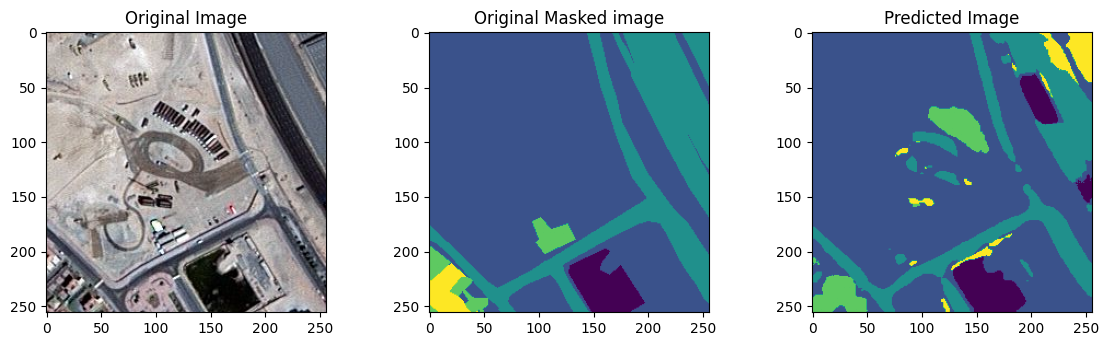

In [61]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)
